In [1]:
import pandas as pd

import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR

from scipy.stats import zscore


# A. How does Equity Respond to a ECB Surprise Hike in Interest Rates?

Instead of using dozens of equity returns and bond yields we are smart and focus on the most import drivers, here Principal Components.

## A.1. Get Data that you want to analyze

**Euro-Area Bond and Equity Data**

In [2]:
# y_{ecb} from I_... / HandlingBigData with PCA
y_ecb = pd.read_csv('y_ecb_2004_2020_d.csv', parse_dates = True, index_col=0) #dates as strings are converted to pandas dataTime format

# equity return Euro area
r_d = pd.read_csv('r_ES50_d_cleaned_realized.csv', parse_dates = True, index_col=0)

**Quick Look at Bond and Equity DataFrames**

In [3]:
y_ecb.head(1)

,0.25 Y,0.5 Y,1 Y,2 Y,3 Y,5 Y,7 Y,10 Y,20 Y,30 Y
TIME_PERIOD,,,,,,,,,,
2004-09-06,2.001665,2.102528,2.297177,2.655494,2.971161,3.483732,3.86532,4.262767,4.853754,5.056951


In [4]:
y_ecb.tail(1)

,0.25 Y,0.5 Y,1 Y,2 Y,3 Y,5 Y,7 Y,10 Y,20 Y,30 Y
TIME_PERIOD,,,,,,,,,,
2020-08-03,-0.514392,-0.506732,-0.494944,-0.474434,-0.446309,-0.352272,-0.219872,-0.000643,0.527303,0.768387


In [5]:
y_ecb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4067 entries, 2004-09-06 to 2020-08-03
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.25 Y  4067 non-null   float64
 1   0.5 Y   4067 non-null   float64
 2   1 Y     4067 non-null   float64
 3   2 Y     4067 non-null   float64
 4   3 Y     4067 non-null   float64
 5   5 Y     4067 non-null   float64
 6   7 Y     4067 non-null   float64
 7   10 Y    4067 non-null   float64
 8   20 Y    4067 non-null   float64
 9   30 Y    4067 non-null   float64
dtypes: float64(10)
memory usage: 349.5 KB


In [6]:
r_d.head(1)

,ADS.DE,AI.PA,ALV.DE,ASML.AS,CS.PA,BBVA.MC,SAN.MC,BAS.DE,BAYN.DE,BMW.DE,...,SU.PA,SIE.DE,TEF.MC,FP.PA,URW.AS,UNA.AS,DG.PA,VIV.PA,VOW.DE,1/N
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.023996,-0.009332,-0.004736,-0.100229,-0.015385,-0.022708,-0.024598,-0.038939,-0.026907,-0.019987,...,-0.042903,-0.034424,-0.047851,-0.025479,-0.000945,0.021525,0.022467,-0.024392,-0.037946,-0.022821


In [7]:
r_d.tail(1)

,ADS.DE,AI.PA,ALV.DE,ASML.AS,CS.PA,BBVA.MC,SAN.MC,BAS.DE,BAYN.DE,BMW.DE,...,SU.PA,SIE.DE,TEF.MC,FP.PA,URW.AS,UNA.AS,DG.PA,VIV.PA,VOW.DE,1/N
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,-0.00515,-0.006642,-0.01922,-0.005675,-0.016905,-0.025786,-0.021381,-0.024147,-0.002435,-0.014715,...,-0.017548,-0.013067,-0.019737,-0.007682,-0.03283,-0.003604,-0.012023,-0.009679,-0.011934,-0.013222


**Merge Data onto same Time Grid**


In [8]:
y = pd.concat([y_ecb, r_d], axis=1, sort=False)
y = y.dropna()
y.shape

(4042, 54)

In [9]:
y.tail(3)

,0.25 Y,0.5 Y,1 Y,2 Y,3 Y,5 Y,7 Y,10 Y,20 Y,30 Y,...,SU.PA,SIE.DE,TEF.MC,FP.PA,URW.AS,UNA.AS,DG.PA,VIV.PA,VOW.DE,1/N
2020-06-29,-0.487048,-0.475471,-0.454654,-0.416438,-0.375757,-0.274145,-0.146811,0.066135,0.652152,0.963723,...,0.013272,0.018099,0.024855,0.002463,0.011663,-0.025595,0.017311,0.008658,0.010486,0.012619
2020-06-30,-0.475513,-0.475883,-0.472561,-0.450750,-0.411471,-0.295425,-0.152041,0.071903,0.627457,0.904619,...,0.002836,0.010170,-0.016579,-0.016783,0.002795,-0.012200,-0.008984,-0.015639,-0.003483,-0.001748
2020-07-01,-0.489772,-0.482524,-0.467215,-0.430012,-0.381347,-0.252288,-0.097620,0.140320,0.705475,0.971891,...,-0.017548,-0.013067,-0.019737,-0.007682,-0.032830,-0.003604,-0.012023,-0.009679,-0.011934,-0.013222


# A.2. Good Luck with the Bruto-Force Approach
1. All y variables are fitted to a VAR
2. IRF is computed: Shock to 0.25 Y (proxy for ECB policy rate) onto stock of interest

$$

$$
Why 'good luck'? 
- curse of dimensionality
- multi-collinearity
- run-time
- missing structure

In [10]:
# Put y into a VAR
VAR_model_1 = VAR(y)

c:\Users\mahsa\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [24]:
corrM = y.corr()
corrM

,0.25 Y,0.5 Y,1 Y,2 Y,3 Y,5 Y,7 Y,10 Y,20 Y,30 Y,...,SU.PA,SIE.DE,TEF.MC,FP.PA,URW.AS,UNA.AS,DG.PA,VIV.PA,VOW.DE,1/N
0.25 Y,1.000000,0.995514,0.982417,0.959495,0.933893,0.875265,0.821330,0.764162,0.701907,0.705286,...,-0.015274,-0.015537,0.014482,-0.001575,0.009635,-0.004837,-0.009438,-0.007534,0.036265,-0.009462
0.5 Y,0.995514,1.000000,0.994644,0.974905,0.950519,0.895878,0.845259,0.790289,0.730106,0.737122,...,-0.015275,-0.015039,0.013662,-0.000880,0.010695,-0.004220,-0.009922,-0.006655,0.037574,-0.008970
1 Y,0.982417,0.994644,1.000000,0.990920,0.972860,0.927913,0.883565,0.833313,0.777233,0.784585,...,-0.013824,-0.012308,0.013941,0.000395,0.012993,-0.002919,-0.009323,-0.005952,0.034170,-0.007241
2 Y,0.959495,0.974905,0.990920,1.000000,0.994789,0.966736,0.932109,0.889557,0.839497,0.842097,...,-0.011312,-0.008940,0.015107,0.001256,0.015577,-0.002316,-0.007876,-0.006326,0.027770,-0.005607
3 Y,0.933893,0.950519,0.972860,0.994789,1.000000,0.987021,0.961693,0.926803,0.882829,0.881702,...,-0.009424,-0.007111,0.016265,0.002106,0.017766,-0.002074,-0.006492,-0.006585,0.024193,-0.004473
5 Y,0.875265,0.895878,0.927913,0.966736,0.987021,1.000000,0.992923,0.973819,0.943400,0.939009,...,-0.006762,-0.004461,0.018219,0.004575,0.022398,-0.000804,-0.004211,-0.006051,0.020079,-0.002076
7 Y,0.821330,0.845259,0.883565,0.932109,0.961693,0.992923,1.000000,0.993810,0.975114,0.969294,...,-0.005216,-0.002564,0.019298,0.006634,0.026075,0.000559,-0.002856,-0.005334,0.017392,-0.000256
10 Y,0.764162,0.790289,0.833313,0.889557,0.926803,0.973819,0.993810,1.000000,0.993061,0.985589,...,-0.004009,-0.000895,0.019918,0.008361,0.029492,0.002010,-0.001833,-0.004700,0.014532,0.001321
20 Y,0.701907,0.730106,0.777233,0.839497,0.882829,0.943400,0.975114,0.993061,1.000000,0.994505,...,-0.003661,-0.000759,0.019367,0.009614,0.032790,0.003419,-0.001245,-0.004438,0.010798,0.002355
30 Y,0.705286,0.737122,0.784585,0.842097,0.881702,0.939009,0.969294,0.985589,0.994505,1.000000,...,-0.005552,-0.003481,0.018051,0.009850,0.032417,0.002258,-0.001871,-0.004585,0.013222,0.001522


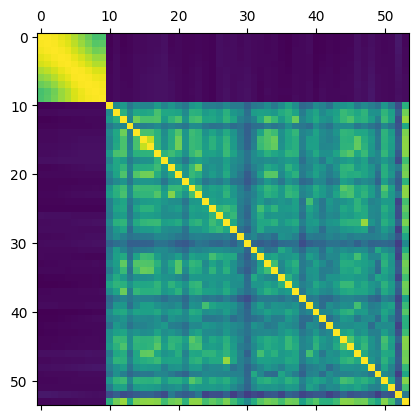

In [22]:
import matplotlib.pyplot as plt

plt.matshow(y.corr())
plt.show()


**The next command produces an Error. I leave it for didactical reasons**

In [16]:
# Let Python choose lag length 'p'. We give in a max lag of 22
VAR_model_1.select_order(1) 

LinAlgError: 54-th leading minor of the array is not positive definite

In [17]:
#Test a VAR(1) fit
VAR_model_1_results = VAR_model_1.fit(1)

VAR_model_1_results.summary() #Warning: Condition Number(!) is (rightly) flagged, ALL Equity tstat / s.e. NAN

LinAlgError: 54-th leading minor of the array is not positive definite

**Same Brute-Force, yet, z-score(y) to have returns and yields on same scale**

In [53]:
#z-score
y_z = y.apply(zscore)

In [54]:
#new VAR model
VAR_model_2 = VAR(y_z)

c:\Users\mahsa\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
#Test a VAR(1) fit 
VAR_model_2_results = VAR_model_2.fit(1)

VAR_model_2_results.summary() 

c:\Users\mahsa\miniconda3\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1558: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, May, 2024
Time:                     16:01:51
--------------------------------------------------------------------
No. of Equations:         54.0000    BIC:                   -148.712
Nobs:                     4041.00    HQIC:                  -151.704
Log likelihood:           3171.88    FPE:                2.52948e-67
AIC:                     -153.345    Det(Omega_mle):     1.21897e-67
--------------------------------------------------------------------
Results for equation 0.25 Y
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000424         0.000372           -1.138           0.255
L1.0.25 Y             0.921440         0.056295           16.368           0.000
L1.0.5 Y              0.083989         0.187808            

**Observation:**

Clearly, regression output **makes no sense at all**


**Think about smart structures instead of simply plugging in everything you like(!!)**

## A.2. 2-dim VAR btw PC1(y_ecb) and PC1(r_d|{1/N})

Some data facts that generalize to other equity and bond data sets

1. PC1(r_d) explains roughly 50% of equity return variance

2. PC1(r_d) mimicks (close to perfectly) the evolution of the equal-weight portfolio, i.e. r_{1/N}

3. Single Index Model for r_d is well-specified if PC1(r_d) or r_{1/N} is used as the single index

4. PC1(y_ecb) explains more than 90% of variance in y_ecb

5. Return on Bonds equals (approx) change in yield times bond's duration

6. Predictability: daily equity returns have 0 auto-correlation. daily yields have 0.99 auto-correlation



Ergo, we set-up the VAR as follows (first principal component of yields and the return on the equal-weight portfolio)

$$
y = [PC1_y, r_{1/N}]
$$
 

**Get PC1's**

In [74]:
from ipynb.fs.defs.Helper_PCA import PCA

#initialize class
PCA_y = PCA(y.iloc[:,:y_ecb.shape[1]])
PCA_y_eq = PCA(y.iloc[:,-r_d.shape[1]:])


#run PCA
PCA_y.PerformEigenValueDecomposition()
PCA_y_eq.PerformEigenValueDecomposition()

**Set-up 2-dim VAR**

<Axes: >

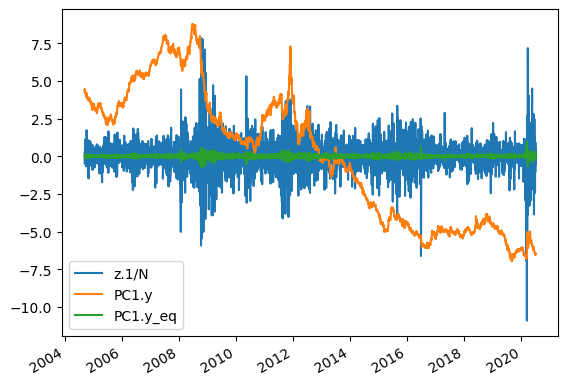

In [75]:
#specify y = (PC1_y, z-score(r_{1/N}))
y2_df = pd.DataFrame()
y2_df["z.1/N"] = zscore(y["1/N"])
y2_df["PC1.y"] = PCA_y.PC[:,0]
y2_df["PC1.y_eq"] = PCA_y_eq.PC[:,0]

y2_df = y2_df.set_index(y.index)

#plot
y2_df.plot()

**Observations**

1. **Equity vol clusters** (2008, 2009, 2011, 2012, 2016, 2020) appear to be **accompanied** by **reversals in interest rates**

$$
\rightarrow \text{that might be a cross asset pattern. More research necessary}
$$

2. My eye bowling: 2008: rates drop prior to vol spike in equity. On other times, equity vol spikes first, followed by a drop in rates

In [66]:
#VAR set-up
VAR_model_3 = VAR(y2_df)

#choose optimal lag length
VAR_model_3.select_order(1) 

c:\Users\mahsa\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
print(VAR_model_3.select_order(1))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>


In [39]:
#we use BIC as information criterion
VAR_model_3_results = VAR_model_3.fit(maxlags=1, ic='bic')

VAR_model_3_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, May, 2024
Time:                     15:45:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.68644
Nobs:                     4041.00    HQIC:                  -4.69249
Log likelihood:          -1973.99    FPE:                 0.00913351
AIC:                     -4.69580    Det(Omega_mle):      0.00911997
--------------------------------------------------------------------
Results for equation z.1/N
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.000051         0.015737           -0.003           0.997
L1.z.1/N        -0.015694         0.015737           -0.997           0.319
L1.PC1.y        -0.000952         0.003566           -0.267           0.790

Res

**Observation**

1. **Surprise reduction in equity prices leads on average to rising bond yields in the next period. Rising bond yields means bond prices drop.**



** A formal judgement about Granger causality is done through IRF analysis.**

**IRFs**

In [46]:
#compute IRF for next 5days
irf_model_3 = VAR_model_3_results.irf(5)

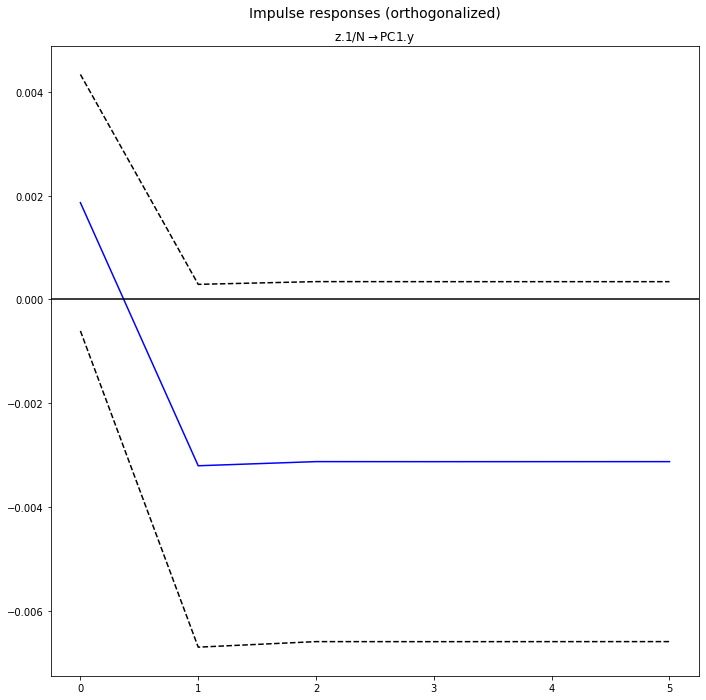

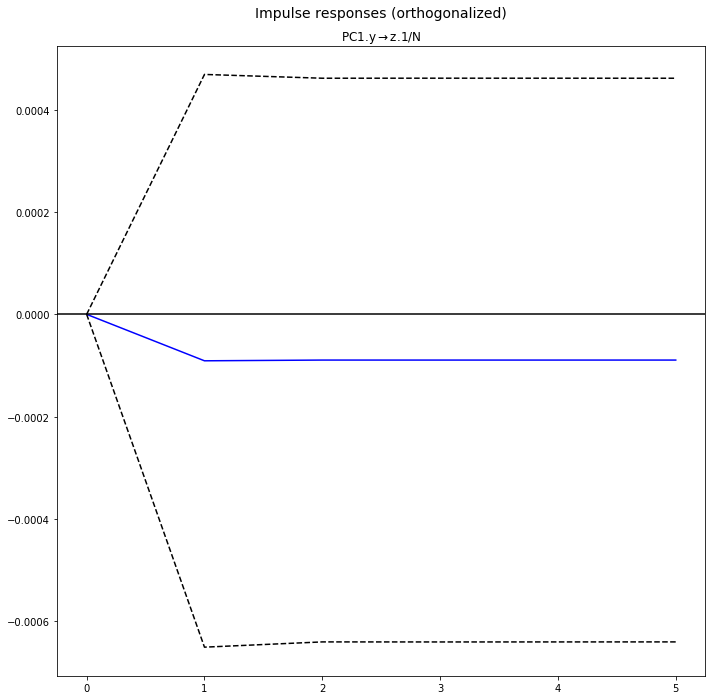

In [29]:
#plot IRF: equity shock on bond yields, 
## CI: 90%, stderr_type: by asymptotic
irf_model_3.plot(impulse="z.1/N", response="PC1.y", orth=True, stderr_type="asym", signif=0.1);
irf_model_3.plot(impulse="PC1.y", response="z.1/N", orth=True, stderr_type="asym", signif=0.1);

**Observation**

1. For the VAR(1), there is no statistically significant Granger causality between equity and bond markets.

